<a href="https://colab.research.google.com/github/miiiingi/dacon_housing/blob/main/dacon_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive/')
my_folder = '/gdrive/MyDrive/ColabNotebooks/dacon_housing/housing'

Mounted at /gdrive/


In [258]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [259]:
trainset = pd.read_csv(f'{my_folder}/train.csv')
trainset = trainset.drop('id', axis = 1)

testset = pd.read_csv(f'{my_folder}/test.csv')
testset = testset.drop('id', axis = 1)

col_numerical = list(set(trainset.describe().columns))
col_categorical = list((set(trainset.columns) - set(col_numerical)))

타겟 변수의 분포를 보니 거의 정규분포로 봐도 무방할 정도의 왜도와 첨도를 가지고 있다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


1.7175856695235343
4.93959283142053


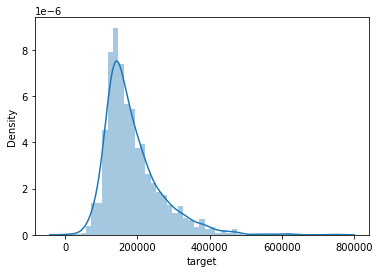

In [301]:
sns.distplot(trainset['target'])
print(trainset['target'].skew())
print(trainset['target'].kurt())

Garage Area(차고 면적) : Garage Cars(차고 자리 개수), target과 높은 상관관계 \\
1st Flr SF(1층 면적) : Total Bstm SF(지하실 면적), target과 높은 상관관계 \\
Garage Yr Blt(차고 완공 연도) : Year Remod Add(리모델링 연도), Year Built(완공 연도) \\
Full Bath(지상층 화장실 갯수) : Gr Liv Area(지상층 생활 면적), target과 높은 상관관계 \\
Gr Liv Area(지상층 생활 면적) : Full Bath, target과 높은 상관관계 \\
Overall Qual(전반적인 품질) : target과 높은 상관관계 \\
target : Garage Area, 1st Flr SF, Garage Cars, Gr Liv Area, Overall Qual, Total Bsmt SF와 높은 상관관계

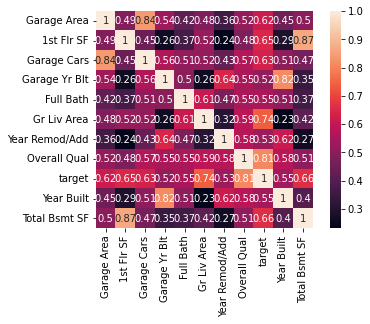

In [303]:
trainset_numerical = pd.DataFrame()
for col in col_numerical : 
  trainset_numerical[col] = trainset[col]
scaler = StandardScaler()
trainset_numerical_corr = pd.DataFrame(scaler.fit_transform(trainset_numerical), columns = col_numerical).corr()
sns.heatmap(trainset_numerical_corr, square = True, annot = True)

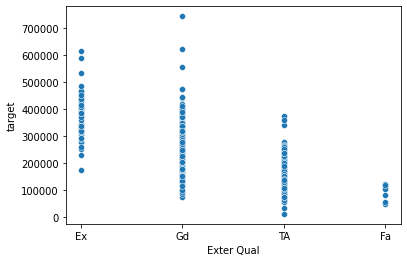

In [260]:
sns.scatterplot(data = trainset, x ='Exter Qual', y = 'target')

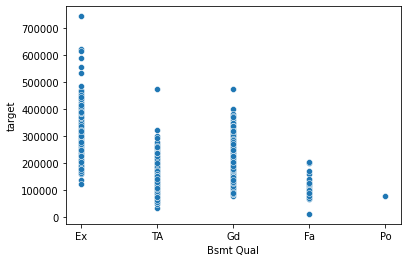

In [261]:
sns.scatterplot(data = trainset, x ='Bsmt Qual', y = 'target')

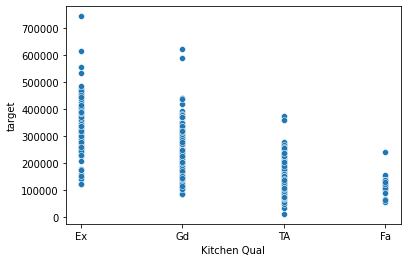

In [262]:
sns.scatterplot(data = trainset, x ='Kitchen Qual', y = 'target')

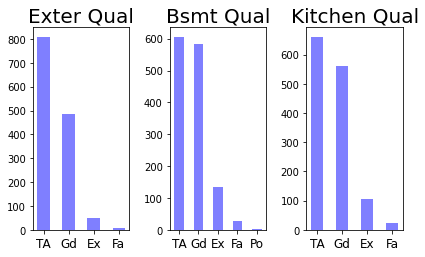

In [263]:
for i in range(len(col_categorical)):
    plt.subplot(1,3,i+1)
    plt.title(col_categorical[i], fontsize=20)
    temp = trainset[col_categorical[i]].value_counts()
    plt.bar(temp.keys(), temp.values, width=0.5, color='b', alpha=0.5)
    plt.xticks(temp.keys(), fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

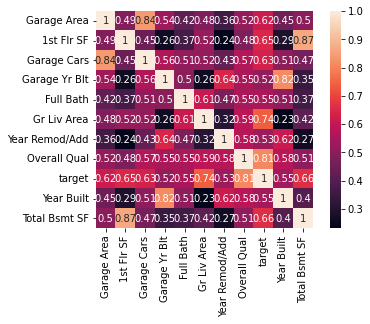

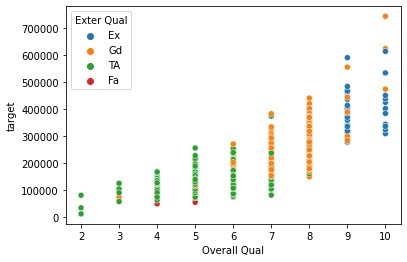

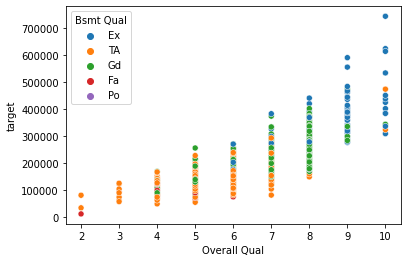

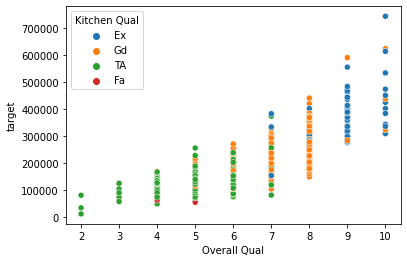

In [269]:
sns.scatterplot(data = trainset, x = 'Overall Qual', y = 'target', hue = 'Exter Qual')
plt.show()
sns.scatterplot(data = trainset, x = 'Overall Qual', y = 'target', hue = 'Bsmt Qual')
plt.show()
sns.scatterplot(data = trainset, x = 'Overall Qual', y = 'target', hue = 'Kitchen Qual')
plt.show()

Bsmt 변수 없앤 것보다 없애지 않은 게 더 성능이 좋음 \\
Kitchen 변수 없앤 것보다 없애지 않은 게 더 성능이 좋음 >> 테스트셋의 Kitchen qual을 살리면 더 성능이 좋을 듯..? \\
Exter Qual은 나누지 않는 게 더 좋을 듯..?


결측치 확인하기 > 결측치가 존재하지 않음 \\
수치 > 평균 0 표준편차 1로 정규화 \\
범주형 > 원핫인코딩

In [ ]:
trainset.loc[trainset['Kitchen Qual'] == 'Gd', 'Kitchen Qual'] = 'Ex'
trainset.loc[(trainset['Kitchen Qual'] == 'TA') | (trainset['Kitchen Qual'] == 'Fa') | (trainset['Kitchen Qual'] == 'Po'), 'Kitchen Qual'] = 'TA'

In [247]:
for col in col_numerical : 
  if sum(trainset[col].isnull()) > 0 :
    print(f'{col} have a null values')
  if col == 'target' : 
    continue
    # mean_target = np.mean(trainset[col])
    # std_target = np.std(trainset[col])
  num_mean = np.mean(trainset[col])
  num_std = np.std(trainset[col])
  trainset[col] = (trainset[col] - num_mean) / num_std
trainset = pd.get_dummies(trainset)

우선 성능이 어느정도 나오는지 체크해보기 위해 제출해보기

In [248]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [249]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import lightgbm as lgbm
import xgboost as xgb
target_train = trainset['target']
data_train = trainset.drop('target', axis = 1)
scorer = make_scorer(NMAE)
reg = LinearRegression()
reg_rf = RandomForestRegressor()
reg_lgbm = lgbm.LGBMRegressor()
reg_xgb = xgb.XGBRegressor()
reg_ensemble = VotingRegressor([('linear', reg), ('rf', reg_rf), ('lgbm', reg_lgbm), ('xgb', reg_xgb)])
reg.fit(data_train, target_train)
reg_rf.fit(data_train, target_train)
reg_lgbm.fit(data_train, target_train)
reg_xgb.fit(data_train, target_train)
reg_ensemble.fit(data_train, target_train)

[06:29:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:29:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


VotingRegressor(estimators=[('linear', LinearRegression()),
                            ('rf', RandomForestRegressor()),
                            ('lgbm', LGBMRegressor()),
                            ('xgb', XGBRegressor())])

In [250]:
print(np.mean(cross_val_score(reg_rf, data_train, target_train, cv = 2, scoring= scorer)))
print(np.mean(cross_val_score(reg_lgbm, data_train, target_train, cv = 2, scoring= scorer)))
print(np.mean(cross_val_score(reg, data_train, target_train, cv = 2, scoring= scorer)))
print(np.mean(cross_val_score(reg_xgb, data_train, target_train, cv = 2, scoring= scorer)))
print(np.mean(cross_val_score(reg_ensemble, data_train, target_train, cv = 2, scoring= scorer)))

0.10160924679866262
0.1053586000917402
0.11170695946225412
[06:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:29:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.10031474886051343
[06:29:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:29:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.09716450927941744


In [251]:
col_numerical.remove('target')

In [252]:
testset.loc[testset['Kitchen Qual'] == 'Gd', 'Kitchen Qual'] = 'Ex'
testset.loc[(testset['Kitchen Qual'] == 'TA') | (testset['Kitchen Qual'] == 'Fa') | (testset['Kitchen Qual'] == 'Po'), 'Kitchen Qual'] = 'TA'

In [253]:
for col in col_numerical : 
  if sum(testset[col].isnull()) > 0 :
    print(f'{col} have a null values')
  num_mean = np.mean(testset[col])
  num_std = np.std(testset[col])
  testset[col] = (testset[col] - num_mean) / num_std
testset = pd.get_dummies(testset)

In [254]:
print(testset.columns)

Index(['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'Total Bsmt SF', '1st Flr SF', 'Full Bath', 'Year Built',
       'Year Remod/Add', 'Garage Yr Blt', 'Exter Qual_Ex', 'Exter Qual_Fa',
       'Exter Qual_Gd', 'Exter Qual_TA', 'Kitchen Qual_Ex', 'Kitchen Qual_TA',
       'Bsmt Qual_Ex', 'Bsmt Qual_Fa', 'Bsmt Qual_Gd', 'Bsmt Qual_Po',
       'Bsmt Qual_TA'],
      dtype='object')


In [255]:
prediction = reg_ensemble.predict(testset)
sample_submission = pd.read_csv(f'{my_folder}/sample_submission.csv')
answer = pd.DataFrame({'id' : sample_submission['id'], 'target' : prediction})
answer.to_csv(f"{my_folder}/submission.csv", index=False)

0.1116 > 0.1131 \\
0.09770789431479524 > 0.09762 \\
0.09716450927941744 > 0.09717
